In [1]:
import sys, os
import numpy as np
import h5py
import random
import neptune
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp

from tensorflow import keras
from tensorflow_probability import layers as tfpl
from tensorflow_probability import distributions as tfd
from tqdm.notebook import tqdm
from tensorflow.keras import Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Input, RepeatVector, MaxPooling2D, Conv2D, Concatenate, UpSampling2D, Conv2DTranspose, Flatten, Dropout, Dense, BatchNormalization, Activation, Reshape, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow_probability.python.distributions import kl_divergence
from neptune.integrations.tensorflow_keras import NeptuneCallback
from DataMaker import *

2023-10-21 16:34:08.590766: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-21 16:34:09.143378: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
LATENT_DIM = 128
BASE_DEPTH = 8
CHANNELS = 5
IMAGE_SHAPE = (CHANNELS, 64, 64)
BATCH_SIZE = 32 * 10
EPOCHS = 250

In [3]:
gpus = tf.config.list_physical_devices('GPU');
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit = 20000)]);
        logical_gpus = tf.config.experimental.list_logical_devices('GPU');
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


2023-10-21 16:34:10.153871: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-21 16:34:10.179184: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-21 16:34:10.179388: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [5]:
channels = 5
BATCH_SIZE = 32

TRAIN_PATH = f'/data/HSC/HSC_v6/step2A/64x64/5x64x64_training.hdf5'
TEST_PATH = f'/data/HSC/HSC_v6/step2A/64x64/5x64x64_testing.hdf5'

gen_args = {
    'X_key': 'image',
    'y_key': 'specz_redshift',
    'scaler': False,
    'labels_encoding': False,
    'batch_size': BATCH_SIZE,
    'shuffle': False}

train_gen = HDF5ImageGenerator(TRAIN_PATH, mode = 'train', **gen_args)
test_gen = HDF5ImageGenerator(TEST_PATH, mode = 'train', **gen_args)
print(train_gen[0][0].shape) # a batch of images
print(train_gen[0][1].shape) # a batch of corresponding redshifts

(320, 5, 64, 64)
(320,)


In [7]:
batch_count = 0
def next_batch():
    global batch_count
    train_set = train_gen[batch_count]
    x_train = np.asarray(train_set[0])
    y_train = train_set[1]
    batch_count = batch_count + 1
    if batch_count == len(train_gen) - 1:
        batch_count = 0
    return x_train, y_train

In [8]:
def build_generator(LATENT_DIM):
    noise = Input(shape = (LATENT_DIM,))
    label = Input(shape = (1,), dtype = 'float32')
    label_embedding = Dense(LATENT_DIM)(label)
    model_input = Concatenate()([noise, label_embedding])
    
    x = Dense(512, activation = "relu", kernel_regularizer = l2(0.01))(model_input)
    x = Dropout(0.2)(x)
    x = Dense(512, activation = "relu", kernel_regularizer = l2(0.01))(x)
    x = Dropout(0.2)(x)
    x = Dense(128 * 16 * 16 + 64 * 16 * 16 + 32 * 32 * 32, activation = "relu")(x)
    x = Dropout(0.2)(x)
    dense1, dense2, dense3 = tf.split(x, [128 * 16 * 16, 64 * 16 * 16, 32 * 32 * 32], axis = 1)
    reshape1 = Reshape((128, 16, 16))(dense1)
    reshape2 = Reshape((64, 16, 16))(dense2)
    reshape3 = Reshape((32, 32, 32))(dense3)
    reshape1 = Dropout(0.2)(reshape1)
    reshape2 = Dropout(0.2)(reshape2)
    reshape3 = Dropout(0.2)(reshape3)
    up1 = UpSampling2D(size = (2, 2), data_format = 'channels_first')(reshape1)
    up1 = Dropout(0.2)(up1)
    conv1 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same', data_format = 'channels_first', kernel_regularizer = l2(0.001))(up1)
    conv1 = Dropout(0.3)(conv1)
    up2 = UpSampling2D(size = (2, 2), data_format = 'channels_first')(reshape2)
    up2 = Dropout(0.2)(up2)
    conv2 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same', data_format = 'channels_first', kernel_regularizer = l2(0.001))(up2 + conv1)
    conv2 = Dropout(0.3)(conv2)
    up3 = UpSampling2D(size = (2, 2), data_format = 'channels_first')(reshape3 + conv2)
    up3 = Dropout(0.2)(up3)
    conv3 = Conv2D(5, (3, 3), activation = 'relu', padding = 'same', data_format = 'channels_first', kernel_regularizer = l2(0.001))(up3)
    conv3 = Dropout(0.3)(conv3)
    
    outputs = Reshape(IMAGE_SHAPE)(conv3)
    
    model = Model([noise, label], outputs)
    return model

In [9]:
def build_discriminator(IMAGE_SHAPE):
    img = Input(shape = IMAGE_SHAPE)
    label = Input(shape = (1,), dtype = 'float32')

    label_embedding = Dense(np.prod(IMAGE_SHAPE))(label)
    label_embedding = Reshape(IMAGE_SHAPE)(label_embedding)
    
    merged_input = Concatenate(axis = 1)([img, label_embedding]) # Concatenate along channels

    conv1 = Conv2D(32, 3, strides = 2, padding = 'same', data_format = 'channels_first', kernel_regularizer = l2(0.001))(merged_input)
    conv1 = BatchNormalization()(conv1)
    conv1 = LeakyReLU(alpha = 0.2)(conv1)
    conv1 = Dropout(0.2)(conv1)
    conv2 = Conv2D(64, 3, strides = 2, padding = 'same', data_format = 'channels_first', kernel_regularizer = l2(0.001))(conv1)
    conv2 = BatchNormalization()(conv2)
    conv2 = LeakyReLU(alpha = 0.2)(conv2)
    conv2 = Dropout(0.2)(conv2)
    conv3 = Conv2D(128, 2, strides = 1, padding = 'same', data_format = 'channels_first', kernel_regularizer = l2(0.001))(conv2)
    conv3 = BatchNormalization()(conv3)
    conv3 = LeakyReLU(alpha = 0.2)(conv3)
    conv3 = Dropout(0.2)(conv3)
    flatten1 = Flatten()(conv1)
    flatten2 = Flatten()(conv2)
    flatten3 = Flatten()(conv3)
    flatten1 = Dropout(0.2)(flatten1)
    flatten2 = Dropout(0.2)(flatten2)
    flatten3 = Dropout(0.2)(flatten3)
    concat = Concatenate()([flatten1, flatten2, flatten3])
    x = Dense(512, activation = "relu", kernel_regularizer = l2(0.001))(concat)
    x = Dropout(0.2)(x)
    x = Dense(512, activation = "relu", kernel_regularizer = l2(0.001))(x)
    x = Dropout(0.2)(x)
    outputs = Dense(1, activation = 'sigmoid')(x)

    model = Model([img, label], outputs)
    return model

In [10]:
def build_gan(generator, discriminator):
    
    discriminator.compile(optimizer = Adam(learning_rate = 1e-5), loss = 'binary_crossentropy', metrics = ['accuracy'])
    discriminator.trainable = False

    noise = Input(shape = (LATENT_DIM,))
    label = Input(shape = (1,))
    img = generator([noise, label])
    fake_pred = discriminator([img, label])

    combined_model = Model([noise, label], fake_pred)
    combined_model.compile(optimizer = Adam(learning_rate = 1e-5), loss = 'binary_crossentropy')
    return combined_model

In [11]:
generator = build_generator(LATENT_DIM)
discriminator = build_discriminator(IMAGE_SHAPE)
gan = build_gan(generator, discriminator)

In [12]:
generator.summary()
discriminator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 128)          256         ['input_2[0][0]']                
                                                                                                  
 concatenate (Concatenate)      (None, 256)          0           ['input_1[0][0]',                
                                                                  'dense[0][0]']              

  0%|          | 0/10 [00:00<?, ?it/s]

2023-10-21 16:27:50.803578: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-10-21 16:27:50.925084: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-10-21 16:27:51.622321: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-10-21 16:27:52.683243: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/dropout_12/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-10-21 16:27:53.030355: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f12d4157fa0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-21 16:27:53.030376: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor devi

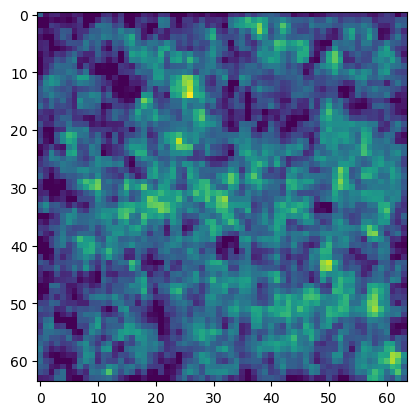

In [13]:
epochs = 10

for epoch in tqdm(range(epochs)):
    
    # Train Discriminator
    noise = np.random.normal(0, 1, (BATCH_SIZE, LATENT_DIM))
    
    fake_redshift = np.random.uniform(0, 4, (BATCH_SIZE, 1))
    
    fake_labels = np.ones((BATCH_SIZE, 1)) * 0.1
    indices_to_change = np.random.choice(BATCH_SIZE, size = int(0.30 * BATCH_SIZE), replace = False)
    fake_labels[indices_to_change] = 0.9
    
    fake_images = generator.predict([noise, fake_redshift], verbose = 0)
    
    # print(fake_images.shape)
    
    real_images, real_redshift = next_batch() # Get a batch of real images
    real_redshift = np.expand_dims(real_redshift, axis = 1)
    
    real_labels = np.ones((BATCH_SIZE, 1)) * 0.9
    indices_to_change = np.random.choice(BATCH_SIZE, size = int(0.30 * BATCH_SIZE), replace = False)
    real_labels[indices_to_change] = 0.1
    
    # print(real_images.shape)
    
    labels = np.vstack([real_labels, fake_labels])
    # print(real_redshift.shape)
    # print(fake_redshift.shape)
    redshifts = np.vstack([real_redshift, fake_redshift])
    # print(real_images.shape)
    # print(fake_images.shape)
    images = np.vstack([real_images, fake_images])
    
    # print(images.shape)
    
    d_loss = discriminator.fit([images, redshifts], labels, batch_size = 32, epochs = 5, shuffle = True, verbose = 0)
    
    real_labels = np.ones((BATCH_SIZE, 1)) * 0.9
    indices_to_change = np.random.choice(BATCH_SIZE, size = int(0.30 * BATCH_SIZE), replace = False)
    real_labels[indices_to_change] = 0.1
    
    # Train Generator
    noise = np.random.normal(0, 1, (BATCH_SIZE, LATENT_DIM))
    fake_redshift = np.random.uniform(0, 2, (BATCH_SIZE, 1)) # a vector of fake redshift to input the generator
    g_loss = gan.fit([noise, fake_redshift], real_labels, batch_size = 32, epochs = 1, shuffle = True, verbose = 0) # train the generator
    
    # if epoch % 5 == 0:
        # print(f"Epoch {epoch}, Discriminator Loss: {d_loss}, Generator Loss: {g_loss}")
        
plt.imshow(fake_images[0][4])

In [12]:
stop here

SyntaxError: invalid syntax (4067800170.py, line 1)

In [14]:
hf = h5py.File('/data/HSC_generated/HSC_generated_v1/step1/64x64/5x64x64_gan_generated_light.hdf5', 'a')
fake_redshift = np.random.uniform(0, 4, (2000, 1))
noise = np.random.normal(0, 1, (2000, LATENT_DIM))
fake_images = generator.predict([noise, fake_redshift])

image_g = fake_images[0][0]
image_r = fake_images[0][1]
image_i = fake_images[0][2]
image_z = fake_images[0][3]
image_y = fake_images[0][4]
    
five_band_image = []
five_band_image.append(image_g)
five_band_image.append(image_r)
five_band_image.append(image_i)
five_band_image.append(image_z)
five_band_image.append(image_y)
    
five_band_image_reshape = np.reshape(np.array(five_band_image), [1, 5, 64, 64])

hf.create_dataset('image', data = five_band_image_reshape, chunks = True, maxshape = (None, 5, 64, 64))
hf.create_dataset('specz_redshift', data = fake_redshift[0], chunks = True, maxshape = (None, ))

for i in tqdm(range(1, 2000)):
    
    image_g = fake_images[i][0]
    image_r = fake_images[i][1]
    image_i = fake_images[i][2]
    image_z = fake_images[i][3]
    image_y = fake_images[i][4]
    
    five_band_image = []
    five_band_image.append(image_g)
    five_band_image.append(image_r)
    five_band_image.append(image_i)
    five_band_image.append(image_z)
    five_band_image.append(image_y)

    hf['specz_redshift'].resize((hf['specz_redshift'].shape[0] + 1), axis = 0)
    hf['specz_redshift'][hf['specz_redshift'].shape[0] - 1] = [fake_redshift[i]]
    hf['image'].resize((hf['image'].shape[0] + 1), axis = 0)
    hf['image'][hf['image'].shape[0] - 1, :, :, :] = five_band_image
hf.close()

63/63 [==============================] - 0s 3ms/step


  0%|          | 0/1999 [00:00<?, ?it/s]

In [373]:
fake_redshift = np.random.uniform(0, 4, (BATCH_SIZE, 1))
noise = np.random.normal(0, 1, (BATCH_SIZE, LATENT_DIM))
fake_images = generator.predict([noise, fake_redshift])

10/10 [==============================] - 0s 2ms/step


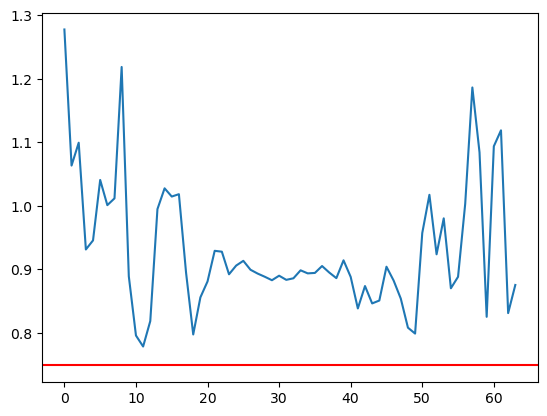

In [374]:
plt.plot(fake_images[2][4][31] / fake_images[3][4][31])
plt.axhline(y = fake_redshift[2][0] / fake_redshift[3][0], xmin=0, xmax=64, color='r')

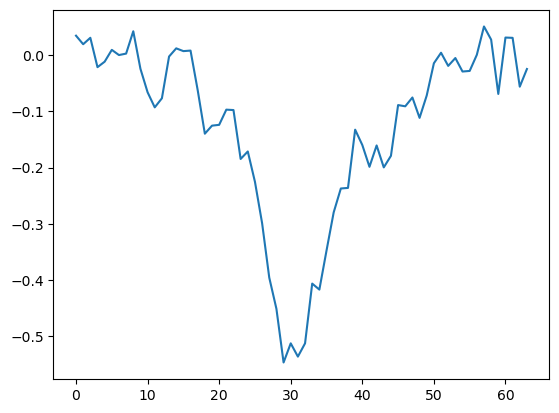

In [375]:
plt.plot(fake_images[2][4][31]-fake_images[3][4][31])

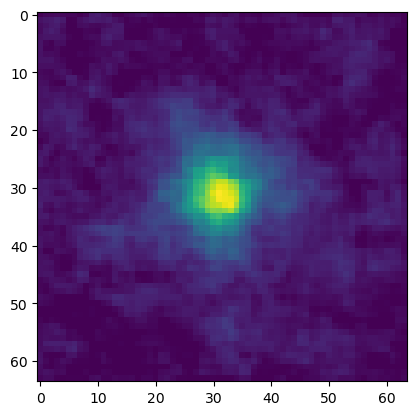

In [390]:
plt.imshow(fake_images[90][3])

In [136]:
from keras.utils.vis_utils import plot_model

plot_model(generator, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [137]:
plot_model(discriminator, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [ ]:
stop here

In [ ]:
model_name = 'gan'

weights_path = os.path.join('/data/tuando/models/', model_name) + '/weights'

In [ ]:
gan.save_weights(weights_path)

In [ ]:
gan.load_weights(weights_path)

In [ ]:
model_name = 'discriminator'

weights_path = os.path.join('/data/tuando/models/', model_name) + '/weights'

In [ ]:
discriminator.save_weights(weights_path)

In [ ]:
discriminator.load_weights(weights_path)

In [ ]:
# END